In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
import keras_tuner as kt
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Mount the google drive and import dataset from there
from google.colab import drive

In [3]:
ROOT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1'
MODEL_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/models'
INPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/data/input'
OUTPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/data/output'
DATASET_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/data/dataset/Apparel images dataset new'

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
drive.mount("/content/drive", force_remount=True)
# os.chdir('/content/drive/My Drive/498')
os.chdir(ROOT_DIR)

Mounted at /content/drive


In [7]:
pwd

'/content/drive/MyDrive/498/WIPDocuments/Code/UseCase1'

In [8]:
# Set the path to the directory containing the folders with images
# data_dir = 'DataSet1/Apparel images dataset new'  # dataset path
  # dataset path

# Initialize an empty list to store image paths and their corresponding category labels
data = []

# Loop through each folder (category) and each image within the folder
for category in os.listdir(DATASET_DIR):
    category_path = os.path.join(DATASET_DIR, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            data.append([image_path, category])

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['image_path', 'category'])

# Save the DataFrame to a CSV file
styles_csv_path = os.path.join(DATASET_DIR, 'styles.csv')
df.to_csv(styles_csv_path, index=False)

print(f'styles.csv has been created at {styles_csv_path}')

styles.csv has been created at /content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/data/dataset/Apparel images dataset new/styles.csv


In [9]:
df_train , df_validate = train_test_split(df, test_size = 0.2, random_state=42)

In [10]:
df_train['category'] = df_train['category'].astype(str)

train_data_generation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_data_generation.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

Found 1730 validated image filenames belonging to 4 classes.


In [11]:
df_validate['category'] = df_validate['category'].astype(str)

validate_data_generation = ImageDataGenerator(
    rescale=1./255,

)

val_gen = validate_data_generation.flow_from_dataframe(
    dataframe=df_validate,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 433 validated image filenames belonging to 4 classes.


In [12]:
# Define model builder function for Keras Tuner
def model_builder(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    model = Sequential([base_model, Flatten()])

    # Tune the number of units in the Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu'))

    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(len(train_gen.class_indices), activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=5, factor=3, directory=MODEL_DIR+'/HP', project_name='Tuner')

Reloading Tuner from /content/drive/MyDrive/498/WIPDocuments/Code/UseCase1/models/HP/Tuner/tuner0.json


In [14]:
# Define callbacks to stop the model early
stop_early = EarlyStopping(monitor='val_accuracy', patience=3) # Stop if val_accuracy doesn't improve for 3 epochs

In [15]:
# Search for the best hyperparameters
tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=[stop_early])

In [16]:
# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Train the best model
model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[stop_early])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 506s 8s/step - accuracy: 0.4947 - loss: 2.7393 - val_accuracy: 0.2194 - val_loss: 1.3870
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.6898 - loss: 0.7711 - val_accuracy: 0.6836 - val_loss: 2.4636
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 610ms/step - accuracy: 0.8042 - loss: 0.6052 - val_accuracy: 0.2356 - val_loss: 1122.7557
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step - accuracy: 0.8505 - loss: 0.4059 - val_accuracy: 0.7344 - val_loss: 7.0975
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.8742 - loss: 0.3457 - val_accuracy: 0.5173 - val_loss: 1.4166


In [18]:
# Feature extraction
feature_extractor = Sequential(model.layers[:-1])
features = feature_extractor.predict(train_gen)

55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 603ms/step


In [19]:
# Find best 3 matching images using cosine similarity
def find_best_matches(input_image_path, features, image_paths):
    # Load the input image with the correct target size (224, 224)
    input_image = load_img(input_image_path, target_size=(224, 224)) # Changed target_size to (224, 224)
    input_image = img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)
    input_image = preprocess_input(input_image)

    input_features = feature_extractor.predict(input_image)
    similarities = cosine_similarity(input_features, features)
    top_indices = np.argsort(similarities[0])[-10:]

    return [image_paths[i] for i in top_indices]

In [20]:
# Example usage
input_image_path = INPUT_DIR+'/apparel_image1.jpg'  # input image path
best_matches = find_best_matches(input_image_path, features, train_gen.filenames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


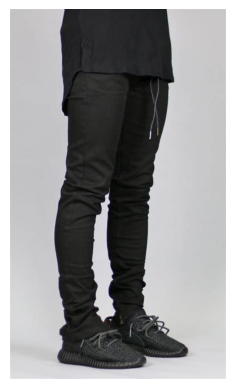

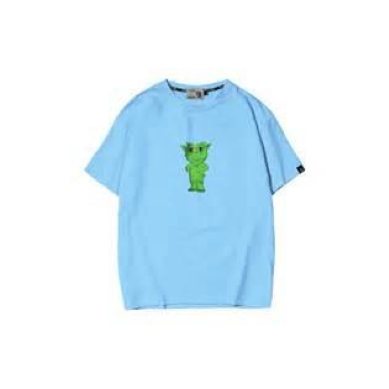

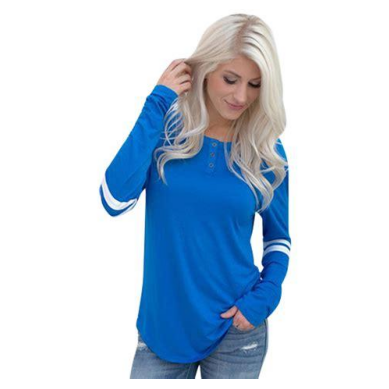

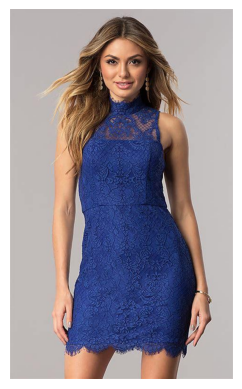

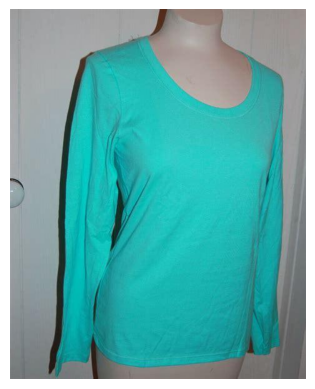

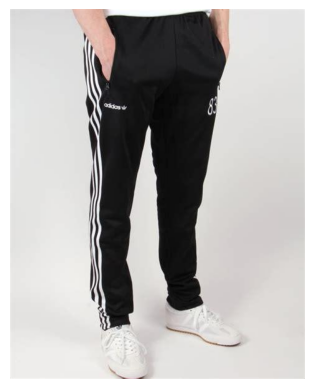

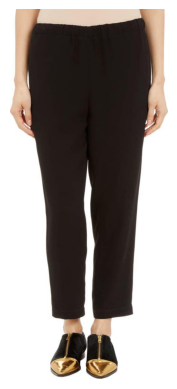

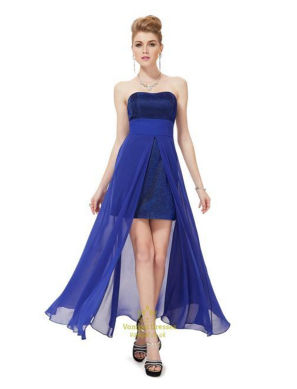

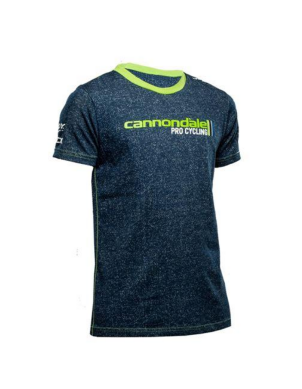

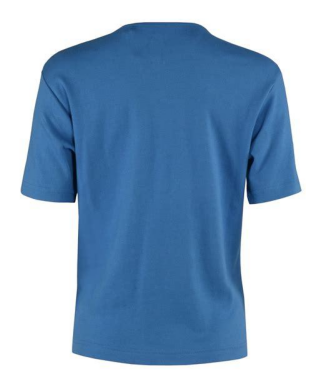

In [21]:
# Display best matches
for match in best_matches:
    img = load_img(match)
    plt.imshow(img)
    plt.axis('off')
    plt.show()